![image.png](attachment:image.png)

In [193]:
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q http://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
# !tar xf spark-3.0.1-bin-hadoop2.7.tgz

# !pip install -q findspark
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"
# !pip install findspark 

# !pip install pyspark

# import findspark
# findspark.init()

# import pyspark

In [194]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession

from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.sql import functions as F


### Data:
- Data is provided in csv format in a file named <b>healthcare-dataset-stroke-data.csv</b>

### Column names and data types are as follow:
- id, integer.
- gender, string.
- age, double.
- hypertension, integer.
- heart_disease, integer.
- ever_married, string.
- work_type, string.
- Residence_type, string.
- avg_glucose_level, double.
- bmi, double.
- smoking_status, string.
- stroke, integer <b>(Target Label)</b>.
If the person has stroke the stroke label value is <b>"1"</b> otherwise <b>"0"</b>.

## To perform this task follow the following guiding steps:

### Create a spark session and import the required libraries

In [195]:
spark = SparkSession.builder.getOrCreate()

In [196]:
df.show(5)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|         0.0|          1.0|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|   1.0|
|51676|Female|61.0|         0.0|          0.0|         Yes|Self-employed|         Rural|           202.21|null|   never smoked|   1.0|
|31112|  Male|80.0|         0.0|          1.0|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|   1.0|
|60182|Female|49.0|         0.0|          0.0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|   1.0|
| 1665|Female|79.0|         1.0|          0.0|         

### Create a data schema programatically

In [197]:
from pyspark.sql.types import *
schema = StructType([StructField("id", IntegerType(), False),
                     StructField("gender", StringType(), False),
                     StructField("age", DoubleType(), False),
                      StructField("hypertension", DoubleType(), False),
                      StructField("heart_disease", DoubleType(), False),
                      StructField("ever_married", StringType(), False),
                      StructField("work_type", StringType(), False),
                      StructField("Residence_type", StringType(), False),
                      StructField("avg_glucose_level", DoubleType(), False),
                      StructField("bmi", DoubleType(), False),
                      StructField("smoking_status", StringType(), False),
                      StructField("stroke", DoubleType(), False)
                     ])

### Read the data using the standard DataReader (Key,Value) pairs format
- Provide the schema and any other required options.

In [198]:
df = spark.read.csv('healthcare-dataset-stroke-data.csv' , header=True , schema=schema)


### Explore the data 
#### You have to do the following:
- Print the Schema.
- Show the first 10 rows from the data.
- Explore null values and show how many null values in each column.
- Plot a count plot for the target label and <b>notice the graph</b>.
- Perform any additional EDA you find useful.

In [199]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: double (nullable = true)
 |-- heart_disease: double (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: double (nullable = true)



In [200]:
df.show(10)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|         0.0|          1.0|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|   1.0|
|51676|Female|61.0|         0.0|          0.0|         Yes|Self-employed|         Rural|           202.21|null|   never smoked|   1.0|
|31112|  Male|80.0|         0.0|          1.0|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|   1.0|
|60182|Female|49.0|         0.0|          0.0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|   1.0|
| 1665|Female|79.0|         1.0|          0.0|         

In [201]:
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|201|             0|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



5110


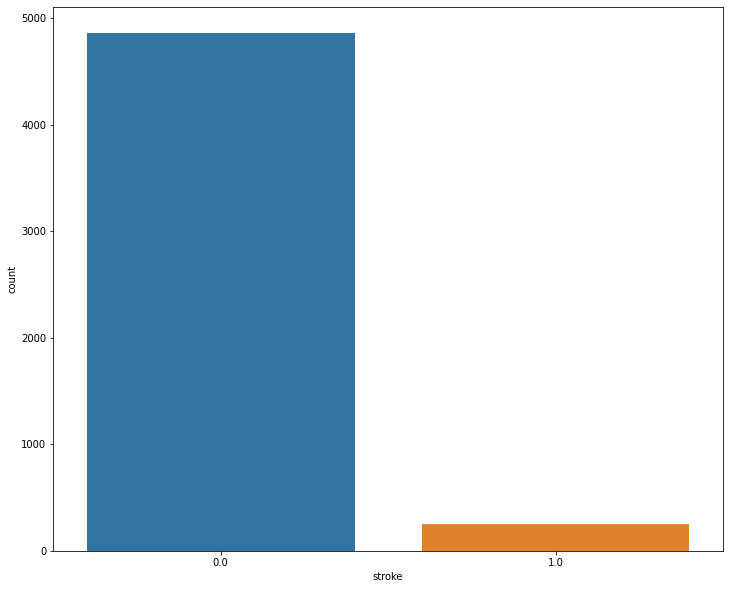

In [202]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pandasDF = df.toPandas()
print(len(pandasDF))
plt.figure(figsize=(12,10))
sns.countplot(x='stroke', data=pandasDF, order=pandasDF['stroke'].value_counts().index)

### Get the summary statistics of the age column
- You will find the minimum age is about <b>0.08</b>.
- Remove rows for the age below <b>2 years old</b>.

In [203]:
df.select('age').describe().show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|              5110|
|   mean|43.226614481409015|
| stddev| 22.61264672311348|
|    min|              0.08|
|    max|              82.0|
+-------+------------------+



In [204]:
df_filtered=df.filter(df.age>2)
df_filtered.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|         0.0|          1.0|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|   1.0|
|51676|Female|61.0|         0.0|          0.0|         Yes|Self-employed|         Rural|           202.21|null|   never smoked|   1.0|
|31112|  Male|80.0|         0.0|          1.0|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|   1.0|
|60182|Female|49.0|         0.0|          0.0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|   1.0|
| 1665|Female|79.0|         1.0|          0.0|         

### Working with gender & smoking_status columns:
- Select and show the gender & smoking_status columns
- Get the distinct values for each column.

In [205]:
df_filtered.select('gender','smoking_status').show()

+------+---------------+
|gender| smoking_status|
+------+---------------+
|  Male|formerly smoked|
|Female|   never smoked|
|  Male|   never smoked|
|Female|         smokes|
|Female|   never smoked|
|  Male|formerly smoked|
|  Male|   never smoked|
|Female|   never smoked|
|Female|        Unknown|
|Female|        Unknown|
|Female|   never smoked|
|Female|         smokes|
|Female|         smokes|
|  Male|        Unknown|
|Female|   never smoked|
|Female|   never smoked|
|  Male|         smokes|
|  Male|         smokes|
|Female|   never smoked|
|  Male|        Unknown|
+------+---------------+
only showing top 20 rows



In [206]:
df_filtered.select('gender').distinct().show()

+------+
|gender|
+------+
|Female|
| Other|
|  Male|
+------+



In [207]:
df_filtered.select('smoking_status').distinct().show()

+---------------+
| smoking_status|
+---------------+
|         smokes|
|        Unknown|
|   never smoked|
|formerly smoked|
+---------------+



#### Change the string values of the columns into numerical values as follow:
1. Gender column:
    * Male = 1 
    * Female = 0 
    * Other = 0 
2. Smoking Status column:
  * never smoked = 0
  * Unknown = 0.5
  * formerly smoked = 0.75
  * smokes = 1.0


In [208]:
convert_map1 = {'Male':1 , 'Female':0 , 'Other':0 } 
convert_map2 = {'never smoked':0 , 'Unknown':0.5 ,'formerly smoked':0.75  ,'smokes' :1 } 


In [209]:
def impute_title1(title):
    return convert_map1[title]
impute_convertUDF1= udf(lambda x: impute_title(x))

def impute_title2(title):
    return convert_map2[title]
impute_convertUDF2= udf(lambda x: impute_title(x))



In [210]:
new_combined = df_filtered.withColumn('Gender',impute_convertUDF1(F.col('gender')))
df_new = new_combined.withColumn('Smoking_status',impute_convertUDF2(F.col('smoking_status')))



#### Show the output DataFrame
- Select and show the gender & smoking_status columns after value changing.
- Print schema for the new dataframe.

In [211]:
df_new.select('Gender','Smoking_status').show()

+------+--------------+
|Gender|Smoking_status|
+------+--------------+
|     1|          0.75|
|     0|             0|
|     1|             0|
|     0|             1|
|     0|             0|
|     1|          0.75|
|     1|             0|
|     0|             0|
|     0|           0.5|
|     0|           0.5|
|     0|             0|
|     0|             1|
|     0|             1|
|     1|           0.5|
|     0|             0|
|     0|             0|
|     1|             1|
|     1|             1|
|     0|             0|
|     1|           0.5|
+------+--------------+
only showing top 20 rows



In [212]:
df_new.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: double (nullable = true)
 |-- heart_disease: double (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- Smoking_status: string (nullable = true)
 |-- stroke: double (nullable = true)



In [213]:
new = df_new.withColumn("Gender",col("Gender").cast("integer"))
new_df = new.withColumn("Smoking_status",col("Smoking_status").cast("Double"))


In [214]:
new_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Gender: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: double (nullable = true)
 |-- heart_disease: double (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- Smoking_status: double (nullable = true)
 |-- stroke: double (nullable = true)



### Deal with null value according to your data analysis.

In [215]:
mean_bmi = new_df.select(F.mean(col('bmi')).alias('mean')).collect()
mean = mean_bmi[0]['mean']
print(mean)

29.257489451476793


In [216]:
final_df = new_df.na.fill(value = mean , subset='bmi')

In [217]:
final_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|  0|             0|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



### Split the data into training and test dataframes:
- 80% training and 20% test.
- seed = 42.
- Save each dataframe as a parquet file

In [218]:
trainDF, testDF = final_df.randomSplit([.8,.2],seed=42)
print(f"There are {trainDF.count()} rows in the training set, and {testDF.count()} in the test set")

There are 3991 rows in the training set, and 944 in the test set


In [219]:
trainDF.write.parquet("output/train1.parquet")
testDF.write.parquet("output/test1.parquet")

### Read the saved Train and Test DataFrame:
- Use the dataframes you read in the subsequent steps.

In [220]:
train_DF=spark.read.parquet("output/train1.parquet")
test_DF=spark.read.parquet("output/test1.parquet")

In [221]:
train_DF.show(5)

+---+------+----+------------+-------------+------------+---------+--------------+-----------------+------------------+--------------+------+
| id|Gender| age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|               bmi|Smoking_status|stroke|
+---+------+----+------------+-------------+------------+---------+--------------+-----------------+------------------+--------------+------+
| 67|     0|17.0|         0.0|          0.0|          No|  Private|         Urban|            92.97|29.257489451476793|          0.75|   0.0|
| 77|     0|13.0|         0.0|          0.0|          No| children|         Rural|            85.81|              18.6|           0.5|   0.0|
| 91|     0|42.0|         0.0|          0.0|          No|  Private|         Urban|            98.53|              18.5|           0.0|   0.0|
| 99|     0|31.0|         0.0|          0.0|          No|  Private|         Urban|           108.89|              52.3|           0.5|   0.0|
|121| 

In [222]:
test_DF.show(5)

+---+------+----+------------+-------------+------------+---------+--------------+-----------------+----+--------------+------+
| id|Gender| age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level| bmi|Smoking_status|stroke|
+---+------+----+------------+-------------+------------+---------+--------------+-----------------+----+--------------+------+
| 84|     1|55.0|         0.0|          0.0|         Yes|  Private|         Urban|            89.17|31.5|           0.0|   0.0|
|129|     0|24.0|         0.0|          0.0|          No|  Private|         Urban|            97.55|26.2|           0.0|   0.0|
|156|     0|33.0|         0.0|          0.0|         Yes|  Private|         Rural|            86.97|42.2|           0.0|   0.0|
|205|     0|43.0|         0.0|          0.0|         Yes|  Private|         Rural|            88.23|37.6|           0.5|   0.0|
|259|     1|79.0|         0.0|          0.0|         Yes|  Private|         Urban|           198.79|24.9

### Create the model:
- Perform feature engineering steps.
- Create the logistic regression classifier.
- Build the pipeline model that uses all feature engineering steps and the model.
- Train the pipeline model using the trainig dataset.

In [223]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.classification import LogisticRegression



In [224]:
df.drop("firstname")

DataFrame[id: int, gender: string, age: double, hypertension: double, heart_disease: double, ever_married: string, work_type: string, Residence_type: string, avg_glucose_level: double, bmi: double, smoking_status: string, stroke: double]

In [225]:
categoricalCols = [field for (field,dataType) in train_DF.dtypes 
                   if dataType == 'string']
indexOutputCols = [x + "_Index" for x in categoricalCols]

oheOutputCols = [x + "_OHE" for x in categoricalCols]

stringIndexer = StringIndexer(inputCols=categoricalCols,
                             outputCols=indexOutputCols,
                             handleInvalid='skip')
oheEncoder = OneHotEncoder(inputCols=indexOutputCols,
                          outputCols=oheOutputCols)

numericCols = [field for (field,dataType) in final_df.dtypes
              if ((dataType=='double' or dataType =='integer')& (field!='stroke'))]

assemblerInputs = oheOutputCols + numericCols

vecAssembler = VectorAssembler(inputCols=assemblerInputs,outputCol='features')



In [226]:
lr = LogisticRegression(labelCol="stroke", featuresCol='features')

pipeline =Pipeline(stages = [stringIndexer,oheEncoder,vecAssembler,lr])

In [227]:
pipelineModel = pipeline.fit(train_DF)
predDF = pipelineModel.transform(test_DF)


### Perform predictions on tests dataframe:
- Test the model using the test dataframe
- Select and show the feature column.
- Print the schema of the output dataframe.
- Select and show both prediction and label columns.
- Explore the results for the label column stroke=1. i.e. select both columns (prediction,stroke) for stroke=1.<b>notice the result.</b> 
- Count the predicted 1 and 0 values.<b>notice the result.</b>   

In [228]:
predDF.select('features','stroke','prediction')

DataFrame[features: vector, stroke: double, prediction: double]

In [229]:
predDF.select('features').show(truncate=False)

+---------------------------------------------------------------------+
|features                                                             |
+---------------------------------------------------------------------+
|(12,[0,1,5,6,9,10],[1.0,1.0,1.0,55.0,89.17,31.5])                    |
|(12,[1,5,6,9,10],[1.0,1.0,24.0,97.55,26.2])                          |
|(12,[0,1,6,9,10],[1.0,1.0,33.0,86.97,42.2])                          |
|(12,[0,1,6,9,10,11],[1.0,1.0,43.0,88.23,37.6,0.5])                   |
|(12,[0,1,5,6,9,10],[1.0,1.0,1.0,79.0,198.79,24.9])                   |
|(12,[0,1,6,9,10],[1.0,1.0,43.0,110.32,28.4])                         |
|(12,[0,2,6,7,9,10],[1.0,1.0,78.0,1.0,75.19,27.6])                    |
|(12,[0,2,5,6,9,10],[1.0,1.0,1.0,74.0,74.96,26.6])                    |
|(12,[4,6,9,10,11],[1.0,14.0,92.22,22.8,0.5])                         |
|(12,[0,1,6,9,10,11],[1.0,1.0,69.0,101.52,26.8,1.0])                  |
|(12,[0,3,6,9,10,11],[1.0,1.0,52.0,87.26,40.1,1.0])             

In [230]:
predDF.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Gender: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: double (nullable = true)
 |-- heart_disease: double (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- Smoking_status: double (nullable = true)
 |-- stroke: double (nullable = true)
 |-- ever_married_Index: double (nullable = false)
 |-- work_type_Index: double (nullable = false)
 |-- Residence_type_Index: double (nullable = false)
 |-- ever_married_OHE: vector (nullable = true)
 |-- work_type_OHE: vector (nullable = true)
 |-- Residence_type_OHE: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [231]:
predDF.select('stroke','prediction').show(10)

+------+----------+
|stroke|prediction|
+------+----------+
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   1.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
+------+----------+
only showing top 10 rows



In [232]:
predDF.select('stroke','prediction').filter('stroke==1').show()

+------+----------+
|stroke|prediction|
+------+----------+
|   1.0|       0.0|
|   1.0|       0.0|
|   1.0|       0.0|
|   1.0|       0.0|
|   1.0|       0.0|
|   1.0|       0.0|
|   1.0|       0.0|
|   1.0|       0.0|
|   1.0|       0.0|
|   1.0|       0.0|
|   1.0|       0.0|
|   1.0|       0.0|
|   1.0|       0.0|
|   1.0|       0.0|
|   1.0|       0.0|
|   1.0|       0.0|
|   1.0|       0.0|
|   1.0|       0.0|
|   1.0|       0.0|
|   1.0|       0.0|
+------+----------+
only showing top 20 rows



In [233]:
predDF.groupby('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  944|
+----------+-----+



### Evaluate the model performance
- Use <b>BinaryClassificationEvaluator</b>. This will calculate the <b>ROC</b>.
- Set the parameters as follow:
    - <b>rawPredictionCol='prediction'</b> and <b>labelCol='stroke'</b>

In [234]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [235]:
evaluatorROC = BinaryClassificationEvaluator(rawPredictionCol='prediction'
                                             ,labelCol='stroke')

In [236]:
evaluatorROC.evaluate(predDF)

0.5

In [237]:
final_df.groupby('stroke').count().show()

+------+-----+
|stroke|count|
+------+-----+
|   0.0| 4687|
|   1.0|  248|
+------+-----+



### Improve Model Performance
- You may noticed that <b>the target label is imbalanced</b>.
- LogisticRegression classifier has a special parameter <b>weightCol</b> to deal with imbalanced class.
- In order to use this parameter you must have a <b>weightCol</b> in your training dataframe.
- In order to create this column you will need to define a <b>UDF</b> and apply it to the target label column.
- Create a LogisticRegression classifier with <b>weightCol</b> parameter.
- Build and train a pipeline model with the new LogisticRegression.
- Perform the prediction on the test dataframe. 
- Select and show both prediction and label columns.
- Explore the results for the label column stroke=1. i.e. select both columns (prediction,stroke) for stroke=1.<b>notice the result.</b> 
- Count the predicted 1 and 0 values.<b>notice the result.</b>   
- Evaluate the model performance exactly as in the previous step.
### YOU SHOULD OBTAIN  ROC > 0.65
<BR>
<b><font color='red'>Note: feel free to deal with the imbalanced cluster with the above method or another. However, you can only use methods applied on SPARK DATAFRAME</font></b>

In [238]:
from pyspark.sql.functions import when
ratio = 0.95

def balance(labels):
    return when(labels == 1, ratio).otherwise(1*(1-ratio))


last_train= train_DF.withColumn('new_weights', balance(col('stroke')))

In [239]:
lr1 = LogisticRegression(labelCol="stroke", featuresCol='features',weightCol='new_weights')
pipeline1 =Pipeline(stages = [stringIndexer,oheEncoder,vecAssembler,lr1])

pipelineModel = pipeline1.fit(last_train)

predDF_final = pipelineModel.transform(test_DF)

evaluatorROC = BinaryClassificationEvaluator(rawPredictionCol='prediction'
                                             ,labelCol='stroke')


In [240]:
evaluatorROC.evaluate(predDF_final)

0.7553336166595834

# GOOD LUCK
<b><font color='GREEN'>AI-PRO Spark Team ITI</font></b>

![image-3.png](attachment:image-3.png)